In [1]:
import numpy as np
import progressbar
from GPyOpt.methods import BayesianOptimization

In [2]:
# honest network delay over next n blocks.
def vectorDelayHonest(ps, es, init_endorsers = 24, delay_priority = 40, delay_endorse = 8):
    return (60 * len(ps)
           + delay_priority * sum(ps) 
           + sum([delay_endorse * max(init_endorsers - e, 0) for e in es]))

# attacking network delay over next n blocks.
def vectorDelayAttacker(ps, es, init_endorsers = 24, delay_priority = 40, delay_endorse = 8):
    return (60 * len(ps) 
           + delay_priority * sum(ps) 
           + sum([delay_endorse * max(init_endorsers - e, 0) for e in es[1:]]))

# efficient sample generation
def getAH(alpha):
    x = np.random.geometric(1-alpha)
    if x == 1:
        h = 0
        a = np.random.geometric(alpha)
    else:
        a = 0
        h = x - 1
    return [a, h]

In [3]:
def getProbReorg(alpha, length, sample_size = int(1e5), init_endorsers = 24, delay_priority = 40, delay_endorse = 8):
    bar = progressbar.ProgressBar()
    feasible_count = 0
    for _ in bar(range(sample_size)):
        aVals = []
        hVals = []
        for i in range(length):
            a, h = getAH(alpha)
            aVals.append(a)
            hVals.append(h)
        eVals = np.random.binomial(32, alpha, size = length)
        honest_delay = vectorDelayHonest(hVals, 32 - eVals)
        selfish_delay = vectorDelayAttacker(aVals, eVals)
        if selfish_delay <= honest_delay:
            feasible_count += 1
    return feasible_count / sample_size

In [4]:
getProbReorg(alpha = 0.45, length = 20)

100% (100000 of 100000) |################| Elapsed Time: 0:00:07 Time:  0:00:07


0.05951

In [11]:
weights_alphas = [(1.0, 0.3), (0.8, 0.35), (0.6, 0.4), (0.4, 0.45), (0.2, 0.49)]
def objective(inputs):
    return sum([weight * getProbReorg(alpha = alpha, length = 20, init_endorsers = inputs[0][0], delay_priority = inputs[0][1], delay_endorse = inputs[0][2]) for (weight, alpha) in weights_alphas])
domain = [{'name': 'init_endorsers', 'type': 'discrete', 'domain': tuple(range(100))}, 
        {'name': 'delay_priority', 'type': 'discrete', 'domain': tuple(range(100))}, 
        {'name': 'delay_endorse', 'type': 'discrete', 'domain': tuple(range(100))}]

In [12]:
opt = BayesianOptimization(f = objective, domain = domain)
opt.run_optimization(max_iter = 100)
opt.plot_acquisition()

100% (100000 of 100000) |################| Elapsed Time: 0:00:08 Time:  0:00:08
100% (100000 of 100000) |################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (100000 of 100000) |################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (100000 of 100000) |################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (100000 of 100000) |################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (100000 of 100000) |################| Elapsed Time: 0:00:08 Time:  0:00:08
100% (100000 of 100000) |################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (100000 of 100000) |################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (100000 of 100000) |################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (100000 of 100000) |################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (100000 of 100000) |################| Elapsed Time: 0:00:08 Time:  0:00:08
100% (100000 of 100000) |################| Elapsed Time: 0:00:08 Time:  0:00:08
100% (100000 of 100000) |###############

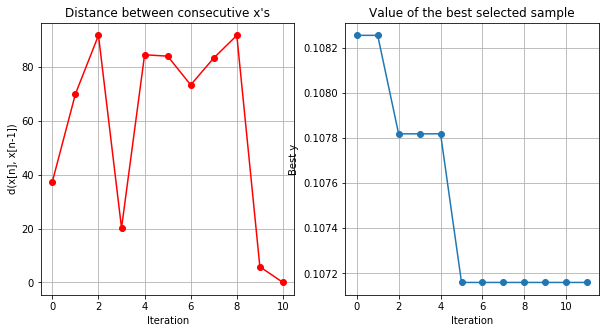

2% (2071 of 100000) |                  | Elapsed Time: 0:00:00 ETA:   0:00:09
X = [init_endorsers delay_priority delay_endorse]

All tested values of X : 
[[25. 25. 59.]
 [13.  2. 32.]
 [ 0. 58. 72.]
 [75.  5. 71.]
 [64.  5. 88.]
 [ 0. 58. 72.]
 [51. 23. 15.]
 [ 6. 57. 62.]
 [62. 42.  2.]
 [ 0. 61. 67.]
 [ 0. 58. 72.]
 [ 0. 58. 72.]]

Corresponding values of Y : 
[[0.108254]
 [0.108808]
 [0.107818]
 [0.108744]
 [0.10844 ]
 [0.10716 ]
 [0.108376]
 [0.108984]
 [0.108388]
 [0.108274]
 [0.108576]
 [0.108212]]

Optimal X : 
[ 0. 58. 72.]
100% (100000 of 100000) |################| Elapsed Time: 0:00:09 Time:  0:00:09
100% (100000 of 100000) |################| Elapsed Time: 0:00:09 Time:  0:00:09
100% (100000 of 100000) |################| Elapsed Time: 0:00:08 Time:  0:00:08
100% (100000 of 100000) |################| Elapsed Time: 0:00:08 Time:  0:00:08
100% (100000 of 100000) |################| Elapsed Time: 0:00:08 Time:  0:00:08
  2% (2201 of 100000) |                  | Elapsed Time: 0:00

In [28]:
opt.plot_convergence()
print("\nX = [init_endorsers delay_priority delay_endorse]")
print("\nAll tested values of X : \n" + str(opt.X))
print("\nCorresponding values of Y : \n" + str(opt.Y))
print("\nOptimal X : \n" + str(opt.x_opt))
print("\nOptimal Y : \n" + str(objective([opt.x_opt])))
print("\nCurrent Tezos : \n" + str(objective([[24, 40, 8]])))